# Reservoir-based Convolution2D

Please refer to [this paper](https://www.jstage.jst.go.jp/article/nolta/13/2/13_397/_article/-char/ja/).

In [ ]:
import numpy as np
import copy

# If GPU is available
import cupy

In [ ]:
class Reservoir(object):
    def __init__(self, i_size, r_size, i_coef=1.0, r_coef=0.999, sparse=0.5, leak=0.5):
        self.w_i = xp.random.uniform(-i_coef, i_coef, (r_size, i_size)).astype(xp.float32)

        #self.w_r = np.random.normal(0, 1, (r_size, r_size)).astype(np.float32)
        self.w_r = np.random.uniform(-1, 1, (r_size * r_size, )).astype(np.float32)
        self.w_r[0:int(r_size * r_size * (1 - sparse))] = 0
        np.random.shuffle(self.w_r)
        self.w_r = self.w_r.reshape(r_size, r_size)
        self.w_r = self.w_r / max(abs(np.linalg.eig(self.w_r)[0])) * r_coef
        self.w_r = xp.array(self.w_r)

        self.leak = leak


    def reset(self, batch):
        self.x = xp.zeros((batch, self.w_r.shape[0]), dtype=xp.float32)


    def __call__(self, u):
        if not u.shape[0] == self.x.shape[0]:
            print('different batchsize')
            print('required:', self.x.shape[0])
            print('actual:', u.shape[0])

        self.x = xp.tanh((1 - self.leak) * self.x + self.leak * (u.dot(self.w_i.T) + self.x.dot(self.w_r.T)), dtype=xp.float32)

        return self.x


    # wrapper function
    def reset_and_call(self, us):
        self.reset(batch=us.shape[1])

        # us: (T, B, C)
        for u in us:
            x = self.__call__(u)

        # x: (B, R) = (B, C)
        return copy.deepcopy(x)

In [ ]:
class ReservoirBasedConvolution2D(object):
    def __init__(self, k_size, stride, padding, in_ch, num_reservoir, num_node, sparse, i_coef=1.0, r_coef=0.999):
        leaks = np.linspace(0.1, 0.9, num_reservoir)
        self.res = [Reservoir(in_ch*k_size, num_node, sparse=sparse, leak=l, i_coef=i_coef, r_coef=r_coef) for l in leaks]

        self.k_size = k_size
        self.stride = stride
        self.padding = padding


    def __call__(self, x):
        # image 2 aois
        aois_h, num_row_h, num_col_h = self._image2aoisH(x, self.k_size, self.stride, self.padding)
        aois_v, num_row_v, num_col_v = self._image2aoisV(x, self.k_size, self.stride, self.padding)

        # H-convolution
        hs_h = []
        for res in self.res:
            h = res.reset_and_call(aois_h)
            hs_h.append(h)

        # (B*N, C) -> (N, B, C) = (H*W, B, C)
        hs_h = xp.concatenate(hs_h, axis=1)
        hs_h = hs_h.reshape(num_row_h*num_col_h, -1, hs_h.shape[1])

        # convs 2 image: (H*W, B, C) -> (B, C, H*W) -> (B, C, H, W)
        images_h = xp.asarray(hs_h)
        images_h = xp.rollaxis(images_h, 0, 3)
        images_h = images_h.reshape(images_h.shape[0], images_h.shape[1], num_row_h, num_col_h)

        # V-convolution
        hs_v = []
        for res in self.res:
            h = res.reset_and_call(aois_v)
            hs_v.append(h)

        # (B*N, C) -> (N, B, C) = (H*W, B, C)
        hs_v = xp.concatenate(hs_v, axis=1)
        hs_v = hs_v.reshape(num_row_v*num_col_v, -1, hs_v.shape[1])

        # convs 2 image: (H*W, B, C) -> (B, C, H*W) -> (B, C, H, W)
        images_v = xp.asarray(hs_v)
        images_v = xp.rollaxis(images_v, 0, 3)
        images_v = images_v.reshape(images_v.shape[0], images_v.shape[1], num_row_v, num_col_v)

        # (B, C, H, W) + (B, C, H, W) -> (B, 2C, H, W)
        images = xp.concatenate([images_h, images_v], axis=1)
        return images


    def _image2aoisH(self, x, k_size, stride, padding):
        # x (B, C, H, W)

        # padding
        x_pad = xp.zeros((x.shape[0], x.shape[1], x.shape[2] + 2*padding, x.shape[3] + 2*padding), dtype=xp.float32)
        x_pad[:, :, padding:padding + x.shape[2], padding:padding + x.shape[3]] = x

        # areas of interest
        aois = []
        num_row = (x_pad.shape[2] - k_size) // stride + 1
        num_col = (x_pad.shape[3] - k_size) // stride + 1
        for h in range(0, x_pad.shape[2] - k_size + 1, stride):
            for w in range(0, x_pad.shape[3] - k_size + 1, stride):
                aoi = x_pad[:, :, h:h+k_size, w:w+k_size]

                # (B, C, H, W) -> (H, B, C, W) -> (H, B, C*W) = (T, B, C*W)
                aoi = xp.rollaxis(aoi, 2, 0)
                aoi = aoi.reshape(aoi.shape[0], aoi.shape[1], -1)

                aois.append(aoi)

        # (T, B*N, C*W)
        aois = xp.concatenate(aois, axis=1)
        return aois, num_row, num_col


    def _image2aoisV(self, x, k_size, stride, padding):
        # x (B, C, H, W)

        # padding
        x_pad = xp.zeros((x.shape[0], x.shape[1], x.shape[2] + 2*padding, x.shape[3] + 2*padding), dtype=xp.float32)
        x_pad[:, :, padding:padding + x.shape[2], padding:padding + x.shape[3]] = x

        # areas of interest
        aois = []
        num_row = (x_pad.shape[2] - k_size) // stride + 1
        num_col = (x_pad.shape[3] - k_size) // stride + 1
        for h in range(0, x_pad.shape[2] - k_size + 1, stride):
            for w in range(0, x_pad.shape[3] - k_size + 1, stride):
                aoi = x_pad[:, :, h:h+k_size, w:w+k_size]

                # (B, C, H, W) -> (W, B, C, H) -> (W, B, C*H) = (T, B, C*H)
                aoi = xp.rollaxis(aoi, 3, 0)
                aoi = aoi.reshape(aoi.shape[0], aoi.shape[1], -1)

                aois.append(aoi)

        # (T, B*N, C*H)
        aois = xp.concatenate(aois, axis=1)
        return aois, num_row, num_col

In [ ]:
def max_pool2d(x, k_size, stride, padding=0):
    # padding
    x_pad = xp.zeros((x.shape[0], x.shape[1], x.shape[2] + 2*padding, x.shape[3] + 2*padding), dtype=xp.float32)
    x_pad[:, :, padding:padding + x.shape[2], padding:padding + x.shape[3]] = x

    # aois
    aois = []
    num_row = (x_pad.shape[2] - k_size) // stride + 1
    num_col = (x_pad.shape[3] - k_size) // stride + 1
    for h in range(0, x_pad.shape[2] - k_size + 1, stride):
        for w in range(0, x_pad.shape[3] - k_size + 1, stride):
            aoi = x_pad[:, :, h:h+k_size, w:w+k_size]
            aoi = aoi.reshape(aoi.shape[0], aoi.shape[1], -1)
            aois.append(aoi)

    # pooling
    aois = xp.array(aois)
    pools = xp.max(aois, axis=3)

    # (H*W, B, C) -> (B, C, H*W)
    pools = xp.array(pools)
    pools = xp.rollaxis(pools, 0, 3)
    pools = pools.reshape(pools.shape[0], pools.shape[1], num_row, num_col)

    return pools

In [ ]:
def ridge_regression(x, t, norm=1.0):
    array = x.T.dot(x)
    array = array + norm * xp.eye(x.shape[1])
    array = xp.linalg.inv(array)
    array = array.dot(x.T)
    array = array.dot(t)

    return array.T

# DATASET

In [ ]:
from sklearn import datasets

In [ ]:
x, t = datasets.fetch_openml('mnist_784', return_X_y=True)
# x, t = datasets.fetch_openml('Fashion-MNIST', return_X_y=True)
# x, t = datasets.fetch_openml('CIFAR_10', return_X_y=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
x = x.values
t = t.values

x_train = x[10000:].astype(np.float32) / 256
t_train = t[10000:].astype(np.int32)
x_test = x[:10000].astype(np.float32) / 256
t_test = t[:10000].astype(np.int32)

In [ ]:
x.shape

(70000, 784)

In [ ]:
t.shape

(70000,)

In [ ]:
import matplotlib.pyplot as plt

(784,)
float32
3


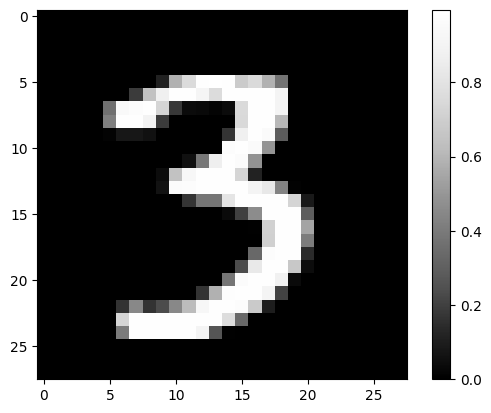

In [ ]:
# mnist, fashion mnist
print(x_train[0].shape)
print(x_train[0].dtype)
print(t_train[0])

plt.imshow(x_train[0].reshape(28, 28), cmap='Greys_r')
plt.colorbar()
plt.show()

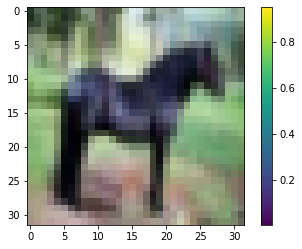

In [ ]:
# cifar10
img = x_train[4].reshape(3, 32, 32)
img = np.rollaxis(img, 0, 3)

plt.imshow(img)
plt.colorbar()
plt.show()

# Train and Test

## Code

In [ ]:
# CPU
# xp = np

# GPU
xp = cupy

In [ ]:
# MNIST
conv1 = ReservoirBasedConvolution2D(k_size=3, stride=1, padding=0, in_ch=1, num_reservoir=5, num_node=12, sparse=0.5)
conv2 = ReservoirBasedConvolution2D(k_size=3, stride=1, padding=0, in_ch=120, num_reservoir=5, num_node=30, sparse=1.0)
w_o = xp.zeros((10, 7501), dtype=xp.float32)

# CIFAR-10
# conv1 = ReservoirBasedConvolution2D(k_size=3, stride=1, padding=0, in_ch=3, num_reservoir=5, num_node=12, sparse=0.5)
# conv2 = ReservoirBasedConvolution2D(k_size=3, stride=1, padding=0, in_ch=120, num_reservoir=5, num_node=30, sparse=0.8)
# w_o = xp.zeros((10, 10801), dtype=xp.float32)

In [ ]:
def forward(x):
    h = conv1(x)
    h = max_pool2d(h, k_size=2, stride=2)
    h = conv2(h)
    h = max_pool2d(h, k_size=2, stride=2)

    h = h.reshape(h.shape[0], -1)
    h_pad = xp.ones((h.shape[0], h.shape[1] + 1), dtype=xp.float32)
    h_pad[:, 0:-1] = h

    y = h_pad.dot(w_o.T)
    return y, h_pad

In [ ]:
BATCH = 100

hs = []
for i in range(0, 60000, BATCH):
# for i in range(0, 50000, BATCH):

    x = xp.array(x_train[i:i+BATCH].reshape(-1, 1, 28, 28)).astype(xp.float32)
    #x = xp.array(x_train[i:i+BATCH].reshape(-1, 3, 32, 32)).astype(xp.float32)

    _, h = forward(x)
    hs.append(h)

    if i % 10000 == 0:
        print(i)

0
10000
20000
30000
40000
50000


In [ ]:
hs = xp.concatenate(hs, axis=0)
ts = xp.eye(10)[xp.array(t_train, dtype=xp.int32)]

In [ ]:
w_o = ridge_regression(hs, ts, norm=400.0)

# check if overfitting
print(np.max(cupy.asnumpy(w_o)))
print(np.min(cupy.asnumpy(w_o)))

In [ ]:
preds = []

for i in range(0, 10000, BATCH):
    x = xp.array(x_test[i:i+BATCH].reshape(-1, 1, 28, 28)).astype(xp.float32)
    # x = xp.array(x_test[i:i+BATCH].reshape(-1, 3, 32, 32)).astype(xp.float32)

    y, _ = forward(x)
    pred = xp.argmax(y, axis=1)
    preds += pred.tolist()

    if i % 1000 == 0:
        print(i)

accuracy = np.sum(np.equal(preds, np.array(t_test, dtype=np.int32))) / 10000
print(accuracy)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0.9817
